## Place field, early phase spikes vs late phase spikes.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting.v0 as ss

from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.v0.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection,IntervalLinearizedPosition

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1
from spyglass.shijiegu.helpers import interpolate_to_new_time
from spyglass.shijiegu.placefield import place_field,placefield_to_peak1dloc
from spyglass.shijiegu.Analysis_SGU import DecodeResultsLinear
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.filterwarnings('ignore')

[2025-02-10 15:39:00,680][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-02-10 15:39:00,859][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [5]:
import matplotlib
from spyglass.shijiegu.helpers import interval_union
from spyglass.shijiegu.Analysis_SGU import (ThetaIntervals,TrialChoice,TrialChoiceChangeOfMind,
        RippleTimes,TetrodeNumber,EpochPos,ExtendedRippleTimes,RippleTimesWithDecode)
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.singleUnit import (do_mountainSort,electrode_unit,RippleTime2FiringRate,findWaveForms,RippleTime2Index,find_spikes
                            )
from spyglass.shijiegu.singleUnit_sortedDecode import place_field_direction
from spyglass.shijiegu.fragmented import permute_frag_cont,find_spike_count_ratio,get_nwb_units,classify_cells,find_firing_cross_correlation
from spyglass.shijiegu.placefield import cell_by_arm
from spyglass.shijiegu.theta import theta_parser_master

from spyglass.shijiegu.changeOfMind_triggered import turnaround_triggered_position
from spyglass.shijiegu.singleUnit_thetaPhase import triggered_theta_mua_animal, find_nearby_trial_time

[15:39:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[15:39:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[15:39:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[15:39:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[15:39:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [6]:
nwb_copy_file_name = "eliot20221021_.nwb"
run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221021_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221021_ 2         02_Seq2Session pos 1 valid ti
eliot20221021_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221021_ 4         04_Seq2Session pos 3 valid ti
eliot20221021_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221021_ 6         06_Seq2Session pos 5 valid ti
eliot20221021_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221021_ 8         08_Seq2Session pos 7 valid ti
eliot20221021_ 9         09_Seq2Sleep5  pos 8 valid ti
 (Total: 9)



In [141]:
epoch_num = 2
session_name = run_session_names[epoch_num]
position_name = pos_session_names[epoch_num]
epoch = run_session_ids[epoch_num]
print(session_name)

06_Seq2Session3


### all place field with all theta phase

In [86]:
(cells, smoothed_placefield, placefield_peak,
            spike_count_by_arm_direction, betaPdfs, means) = place_field_direction(nwb_copy_file_name,
                                                                                   session_name,position_name,
                                                                                   curation_id = 1)

[16:32:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[16:32:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[16:32:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[16:32:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[16:32:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackG

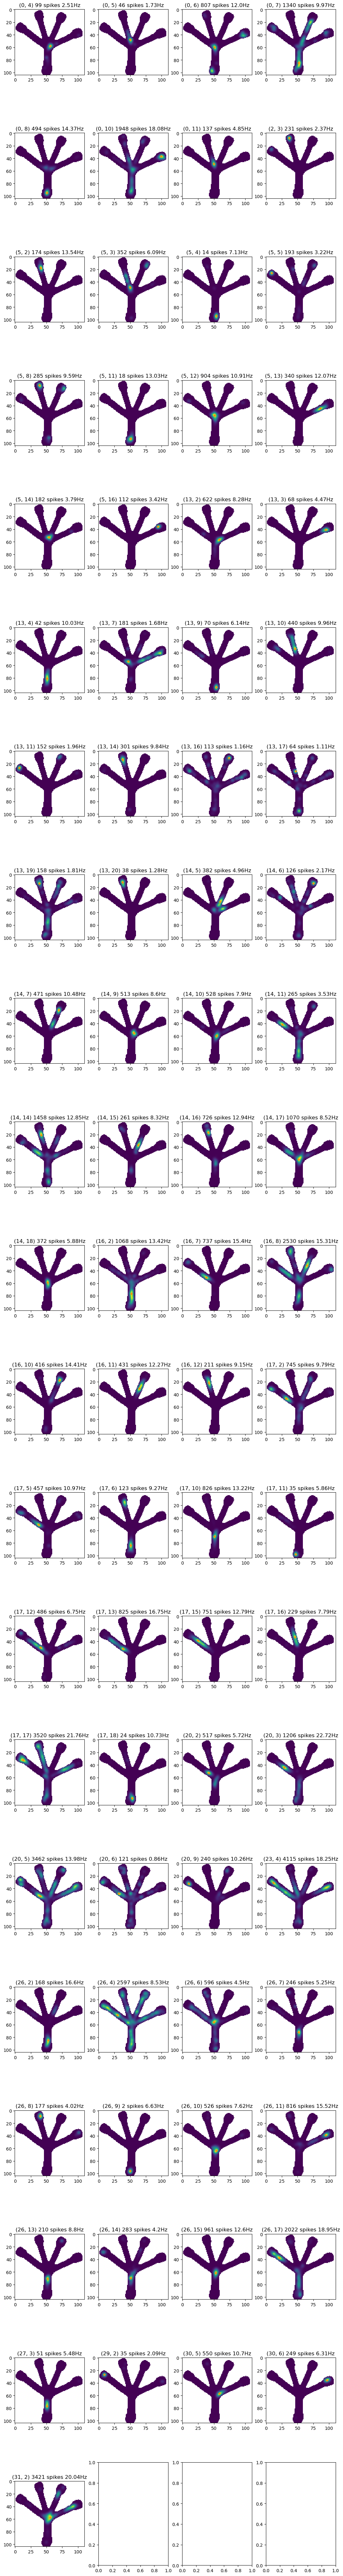

In [87]:
cells = list(spike_count_by_arm_direction.keys())
fig_row_num = int(np.ceil(len(cells)/4))
fig, axes = plt.subplots(fig_row_num, 4, figsize = (13,5*fig_row_num), squeeze = True)

ind = 0
for cell in cells:
    (e,u) = cell
    placefield = smoothed_placefield[(e,u)]
    
    axes[np.unravel_index(ind, axes.shape)].imshow(placefield)

    # peak location
    max_ind = np.unravel_index(np.nanargmax(placefield),placefield.shape)
    xbins = np.arange(placefield.shape[1])
    ybins = np.arange(placefield.shape[0])
    max_location_2D = (xbins[max_ind[1]],ybins[max_ind[0]])
    axes[np.unravel_index(ind, axes.shape)].scatter(max_location_2D[0],max_location_2D[1],marker='+',color = "C1")
    
    axes[np.unravel_index(ind, axes.shape)].set_title(str((e,u))+" "+str(
                int(np.nansum(spike_count_by_arm_direction[(e,u)])))+" spikes "+str(np.round(np.nanmax(placefield),2))+"Hz")
    #axes[np.unravel_index(ind, axes.shape)].text(200,-10,round(peak_frs[(e,u)],1))
    ind = ind + 1

animal = nwb_copy_file_name[:5]
output_folder = f'/cumulus/shijie/recording_pilot/{animal}/changeOfMind'
filename = animal+'_'+nwb_copy_file_name+'_'+session_name+'_placefields'
if len(output_folder)>0:
    plt.savefig(os.path.join(output_folder,filename+'.pdf'),format="pdf",bbox_inches='tight',dpi=200)

In [10]:
## load theta
theta_times_path = (ThetaIntervals() & {'nwb_file_name': nwb_copy_file_name,
                    'interval_list_name': session_name}).fetch1("theta_times")
theta_times = pd.read_csv(theta_times_path)

In [12]:
sort_group_ids = np.unique((Curation() & {'nwb_file_name': nwb_copy_file_name,"curation_id":1}).fetch("sort_group_id"))
nwb_units_all = get_nwb_units(
            nwb_copy_file_name,session_name,sort_group_ids,curation_id = 1)

cells = []
for e in nwb_units_all.keys():
    if nwb_units_all[e] is None:
        continue
    for u in nwb_units_all[e].index:
        cells.append((e,u))

### place code contrast

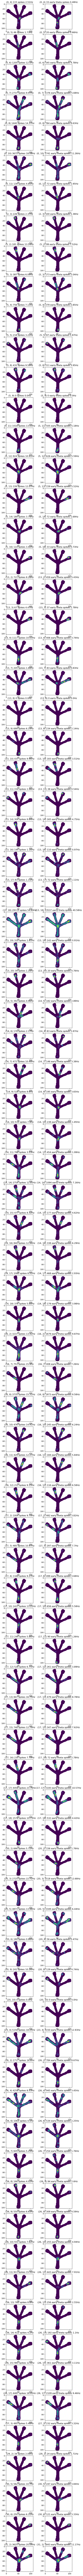

In [140]:
fig_row_num = int(len(cells))
fig, axes = plt.subplots(fig_row_num, 2, figsize = (7,3*fig_row_num))

ind = 0
for (e,u) in cells:
    # all spikes
    spike_count = {}
    (smoothed_placefield, peak_firing_rate, 
     xbins, ybins,
     spike_count[(e,u)], _
    ) = place_field(nwb_copy_file_name, session_name, position_name, e, u, 
                    BINWIDTH = 2, sigma = 2, curation_id = 1, nwb_units = nwb_units_all[e].loc[[u]])
    ### early theta
    late_phase = False

    # electrode unit spike times
    eu_spike_times = np.concatenate(np.array(nwb_units_all[e].loc[[u]].spike_times)) 
    
    eu_spike_times_cut = [] # electrode unit spike times with limited theta phase
    for theta_ind in range(len(theta_times)):
        intvl = eval(theta_times.loc[theta_ind].theta_interval)
        if late_phase:
            t0 = (intvl[0] + intvl[1]) / 2
            t1 = intvl[1]
        else:
            t0 = intvl[0]
            t1 = (intvl[0] + intvl[1]) / 2
        
    
        eu_spike_times_theta = eu_spike_times[np.logical_and(eu_spike_times >= t0, eu_spike_times <= t1)]
        eu_spike_times_cut.append(eu_spike_times_theta)
        
    eu_spike_times_cut = np.concatenate(eu_spike_times_cut)
    
    nwb_units_eu = pd.DataFrame({'id':u,'spike_times':[eu_spike_times_cut]})
    nwb_units_eu = nwb_units_eu.set_index('id')

    spike_count_early_phase = {}
    (smoothed_placefield_early_phase, peak_firing_rate_early_phase, 
     xbins, ybins,
     spike_count_early_phase[(e,u)], _
    ) = place_field(nwb_copy_file_name, session_name, position_name, e, u, 
                    BINWIDTH = 2, sigma = 2, curation_id = 1, nwb_units = nwb_units_eu)

    """do plotting"""
    axes[ind, 0].imshow(smoothed_placefield)

    # peak location
    max_ind = np.unravel_index(np.nanargmax(smoothed_placefield),smoothed_placefield.shape)
    xbins = np.arange(smoothed_placefield.shape[1])
    ybins = np.arange(smoothed_placefield.shape[0])
    max_location_2D = (xbins[max_ind[1]],ybins[max_ind[0]])
    axes[ind, 0].scatter(max_location_2D[0],max_location_2D[1],marker='+',color = "C1")
    
    axes[ind, 0].set_title(str((e,u))+" "+str(spike_count[(e,u)])+" spikes "+str(np.round(np.nanmax(smoothed_placefield),2))+"Hz")


    axes[ind, 1].imshow(smoothed_placefield_early_phase)

    # peak location
    max_ind = np.unravel_index(np.nanargmax(smoothed_placefield_early_phase),smoothed_placefield_early_phase.shape)
    xbins = np.arange(smoothed_placefield_early_phase.shape[1])
    ybins = np.arange(smoothed_placefield_early_phase.shape[0])
    max_location_2D = (xbins[max_ind[1]],ybins[max_ind[0]])
    axes[ind, 1].scatter(max_location_2D[0],max_location_2D[1],marker='+',color = "C1")
    
    axes[ind, 1].set_title(str((e,u))+" "+str(spike_count_early_phase[(e,u)])+" early theta spikes "+str(np.round(np.nanmax(smoothed_placefield_early_phase),2))+"Hz")
    #axes[np.unravel_index(ind, axes.shape)].text(200,-10,round(peak_frs[(e,u)],1))
    
    ind = ind + 1

### 1. Get spike

In [7]:
key = {"nwb_file_name": nwb_copy_file_name,
       "sorter":"mountainsort4",
       "sort_interval_name":session_name}

sort_group_ids = np.unique((QualityMetrics & key).fetch("sort_group_id"))
sort_group_ids_with_good_cell = []
for sort_group_id in sort_group_ids:
    nwb_units = electrode_unit(nwb_copy_file_name,session_name,sort_group_id)
    if len(nwb_units)==0:
        continue
    sort_group_ids_with_good_cell.append(sort_group_id)
print("sort groups are: ",sort_group_ids_with_good_cell)

nwb_units_all = get_nwb_units(nwb_copy_file_name,session_name,sort_group_ids_with_good_cell)
count_ratio, firing_rate_F, firing_rate_C = find_spike_count_ratio(nwb_units_all,ripple_times)
cells_frag, cells_cont = classify_cells(firing_rate_F, firing_rate_C)

cell_list = []
for e in sort_group_ids_with_good_cell:
    for u in nwb_units_all[e].index:
        cell_list.append((e, u))

sort groups are:  [0, 2, 5, 13, 14, 16, 17, 20, 23, 26, 27, 30, 31]
electrode 0 unit 3
during fragmented replay:  7.304430676138095 31.0
during cont replay:  3.709264109928835 84.0
electrode 0 unit 4
during fragmented replay:  0.23562679600445469 1.0
during cont replay:  0.04415790607058137 1.0
electrode 0 unit 6
during fragmented replay:  2.8275215520534562 12.0
during cont replay:  1.9871057731761617 45.0
electrode 0 unit 7
during fragmented replay:  3.5344019400668203 15.0
during cont replay:  0.7506844031998833 17.0
electrode 0 unit 8
during fragmented replay:  1.1781339800222734 5.0
during cont replay:  0.1324737182117441 3.0
electrode 2 unit 3
during fragmented replay:  2.356267960044547 10.0
during cont replay:  1.1481055578351156 26.0
electrode 5 unit 2
during fragmented replay:  0.0 0.0
during cont replay:  0.9273160274822088 21.0
electrode 5 unit 5
during fragmented replay:  2.120641164040092 9.0
during cont replay:  0.30910534249406957 7.0
electrode 5 unit 6
during fragmente

### 2. Load theta phase and position

In [8]:
from spyglass.shijiegu.load import load_theta_maze
from spyglass.shijiegu.Analysis_SGU import get_linearization_map,segment_to_linear_range
from spyglass.shijiegu.theta import return_skaggs_theta, return_theta_phase_location

import xarray as xr
import scipy

In [ ]:
theta_df, pos1d, pos2d = return_skaggs_theta(nwb_copy_file_name,pos_name,session_name,
                                             nwb_units_all,cell_list)
linear_map, welllocations = get_linearization_map()

In [124]:
# for inspection
# theta_xr_test = theta_xr.sel(time = slice(theta_xr.time[0],theta_xr.time[1000]))

# plt.plot(theta_xr_test.time,theta_xr_test[0]/100)
# plt.plot(theta_xr_test.time,np.cos(theta_xr_test['phase0']))

### 4. phase precession plot

In [83]:
from sklearn.linear_model import LinearRegression
def fit_theta_phase_location(pos_phase,arms):
    score = {}
    model = {}
    for direction in pos_phase.keys():
        x = pos_phase[direction][0]
        y = pos_phase[direction][1]
        if len(x) > 0:
            model[direction] = LinearRegression().fit(np.array(x).reshape((-1,1)), np.array(y).reshape((-1,1)))
            score[direction] = model[direction].score(np.array(x).reshape((-1,1)), np.array(y).reshape((-1,1)))
        else:
            score[direction] = np.nan
        
    return model,score

#### TO DO: do circular regression using complex number regression:

https://www.chrishenson.net/posts/2020-06-19-complex_regression.html

#### for one neuron

In [121]:
unitID = (13,7)
pos_phase,arms = return_theta_phase_location(pos1d,pos2d,theta_df,nwb_units_all,unitID)
model,score = fit_theta_phase_location(pos_phase,arms)

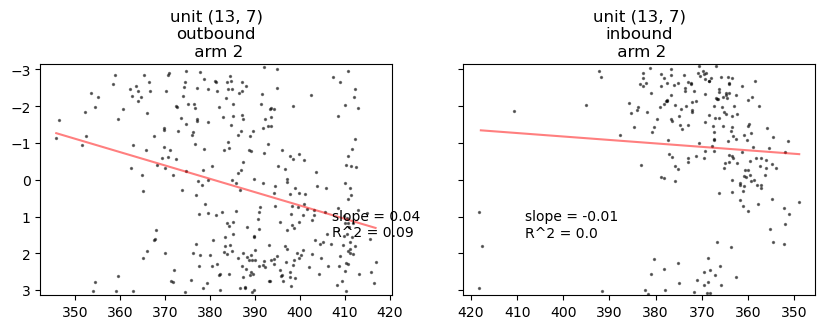

In [122]:
fig,axes=plt.subplots(1,2,figsize=(10,3),sharey= True)

ind = 0
for direction in pos_phase.keys():
    arm = arms[direction]
    axes[ind].set_title('unit ' + str(unitID) + '\n' +direction + '\n arm '+str(arm))
    x = pos_phase[direction][0]
    y = pos_phase[direction][1]
    
    axes[ind].scatter(x, y, s = 2, color = 'k', alpha = 0.5)
    axes[ind].set_ylim([-np.pi,np.pi])

    """do fitting"""
    x_ = np.arange(x.min(),x.max())
    y_ = model[direction].predict(x_.reshape(-1,1)).ravel()
    axes[ind].plot(x_, y_, color = 'red', alpha = 0.5)
    axes[ind].text(x.max()-10,0.5*y.max(),
                   "slope = " + str(round(model[direction].coef_[0][0],2))+"\n"+
                   "R^2 = " + str(round(score[direction],2)))
    
    if direction == 'inbound':
        axes[ind].invert_xaxis()
    axes[ind].invert_yaxis()
    
    ind += 1

In [112]:
def plot_theta_phase_precession(pos_phase,arms,model,score,unitID):
    
    fig,axes=plt.subplots(1,2,figsize=(10,3),sharey= True)

    ind = 0
    for direction in pos_phase.keys():
        arm = arms[direction]
        axes[ind].set_title('unit ' + str(unitID) + '\n' +direction + '\n arm '+str(arm))
        x = pos_phase[direction][0]
        y = pos_phase[direction][1]
        
        axes[ind].scatter(x, y, s = 2, color = 'k', alpha = 0.5)
        axes[ind].set_ylim([-np.pi,np.pi])
    
        """do fitting"""
        if len(x) > 2:
            x_ = np.arange(x.min(),x.max())
            if len(x_) > 2:
                y_ = model[direction].predict(x_.reshape(-1,1)).ravel()
                axes[ind].plot(x_, y_, color = 'red', alpha = 0.5)
                axes[ind].text(x.max()-10,0.5*y.max(),
                           "slope = " + str(round(model[direction].coef_[0][0],2))+"\n"+
                           "R^2 = " + str(round(score[direction],2)))
        #except:
        #    pass
        axes[ind].invert_yaxis()
        if direction == 'inbound':
            axes[ind].invert_xaxis()
        
        ind += 1

#### for many neurons

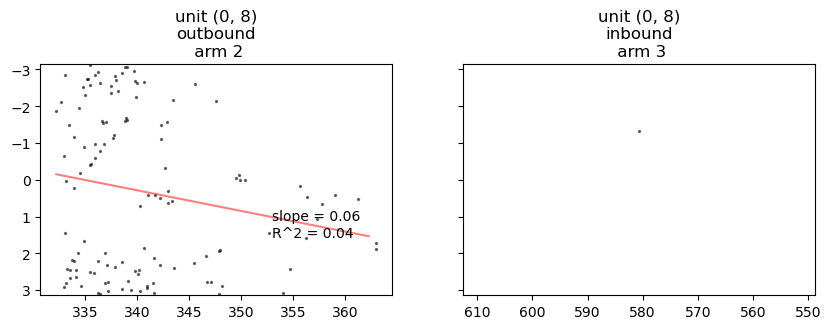

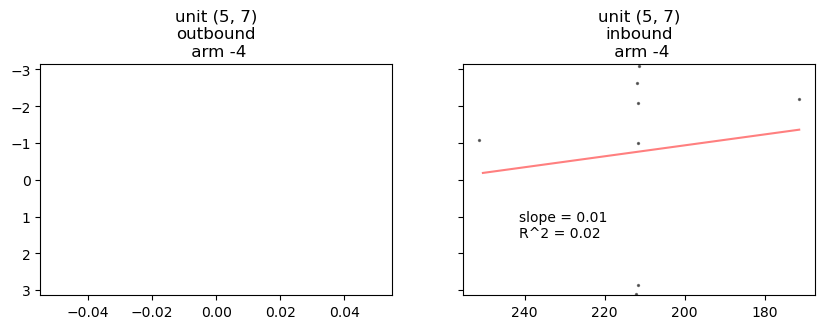

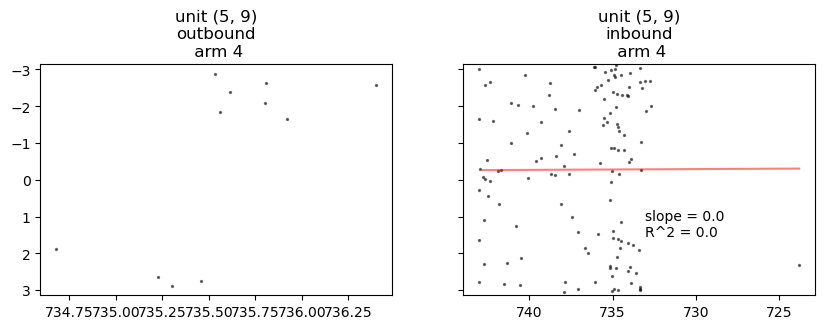

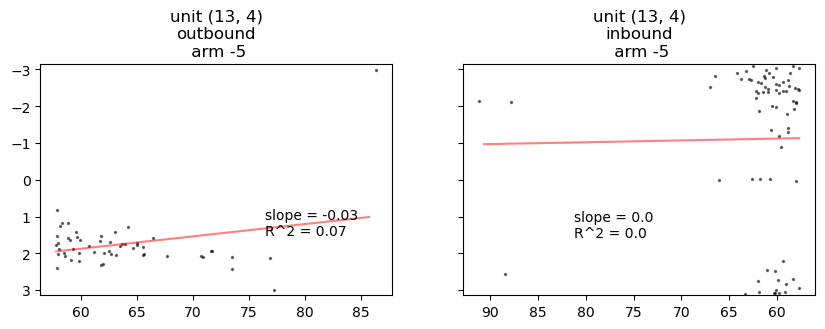

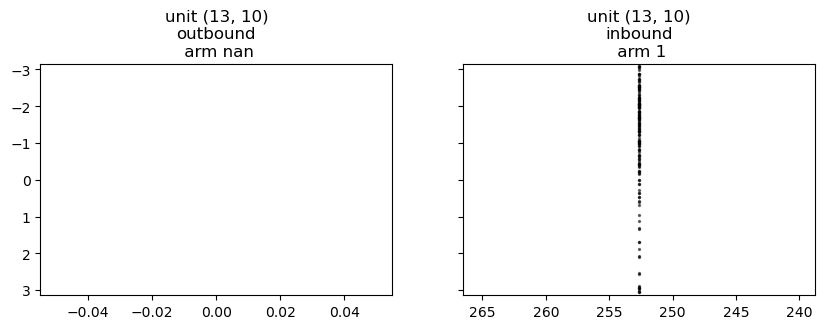

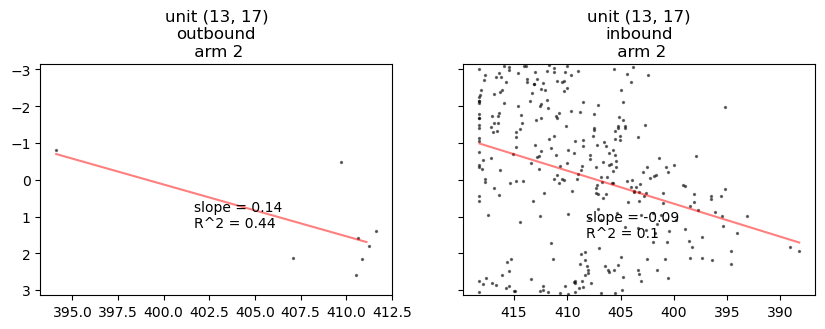

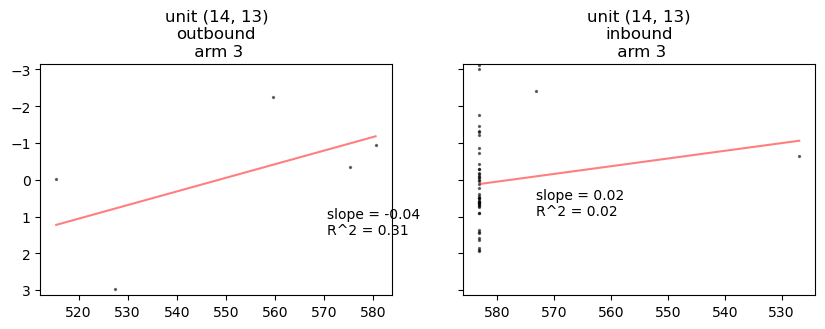

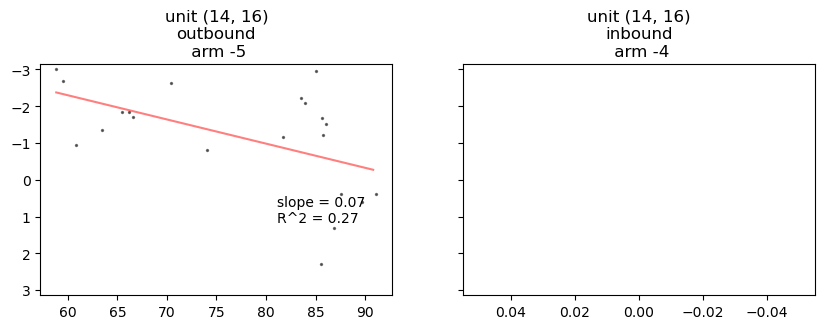

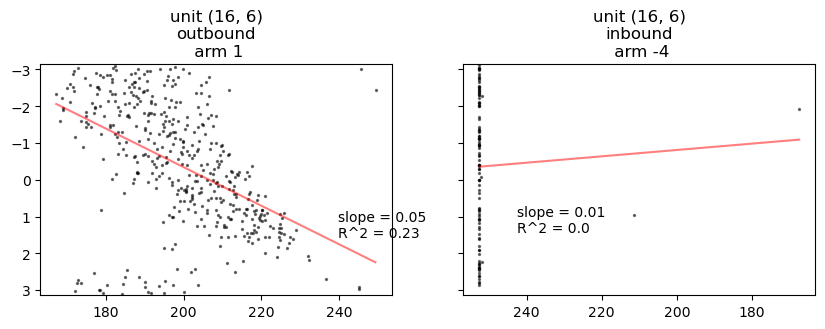

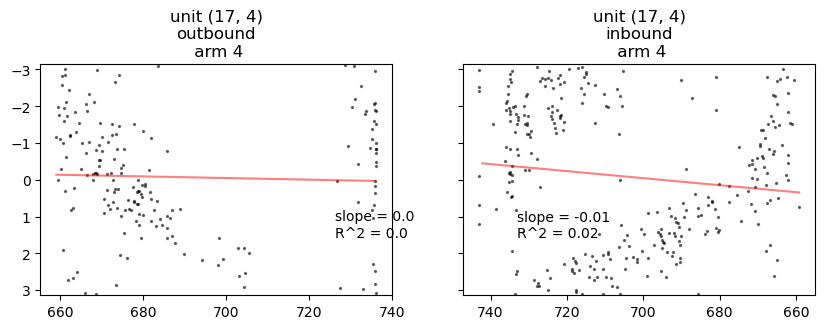

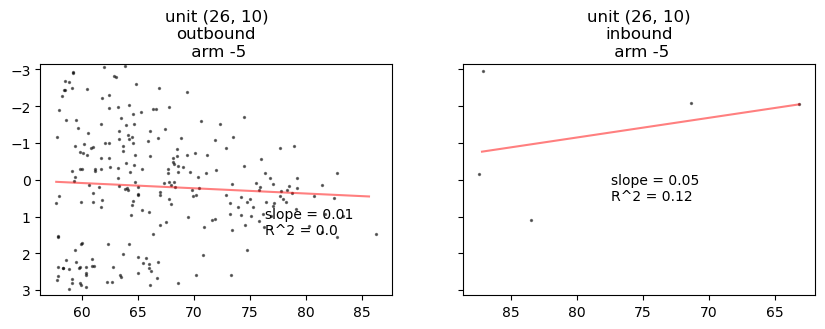

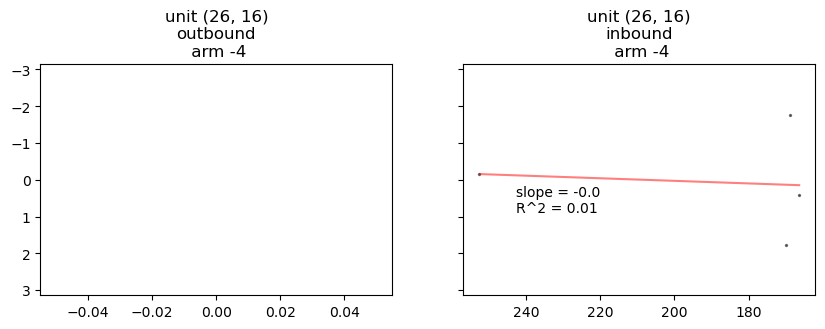

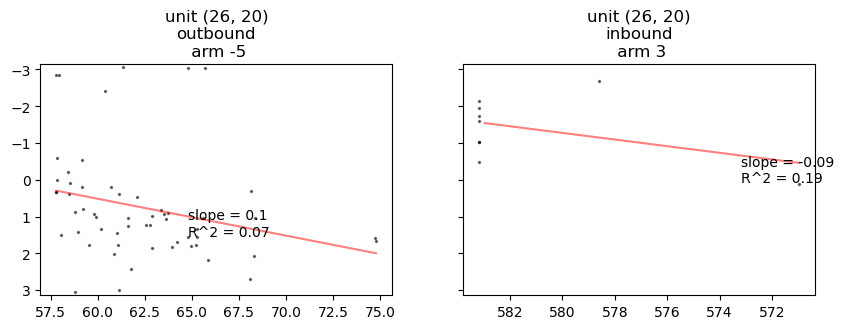

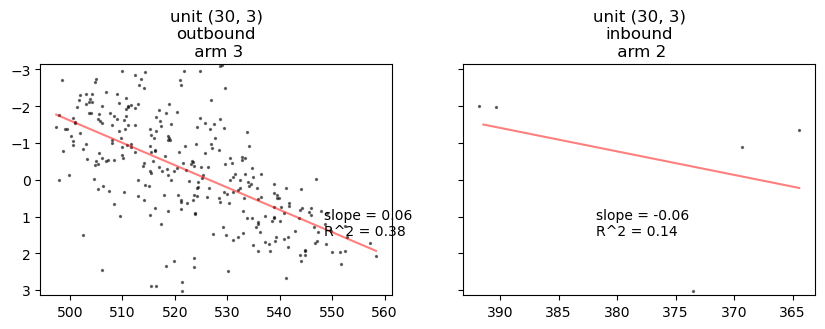

In [113]:
coef_all_frag = []
score_all_frag = []

for unitID in cells_frag:
    pos_phase,arms = return_theta_phase_location(pos1d,pos2d,theta_df,nwb_units_all,unitID)
    model,score = fit_theta_phase_location(pos_phase,arms)

    # find direction
    scores = np.array([score['outbound'],score['inbound']])
    if np.sum(np.isnan(scores)) == 2:
        continue
    direction = np.nanargmax(scores)
    if direction == 0:
        coef = model['outbound'].coef_[0][0]
    else:
        coef = -model['inbound'].coef_[0][0]
    
    score_all_frag.append(scores[direction])
    coef_all_frag.append(coef)

    # plot
    plot_theta_phase_precession(pos_phase,arms,model,score,unitID)


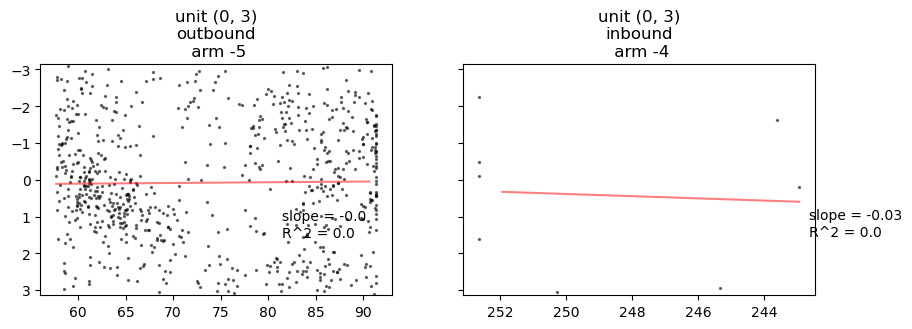

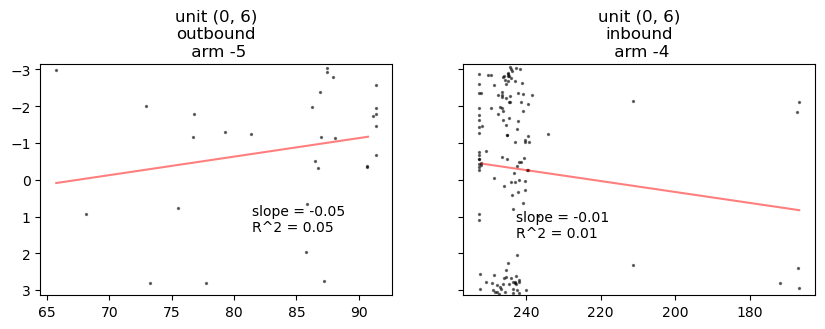

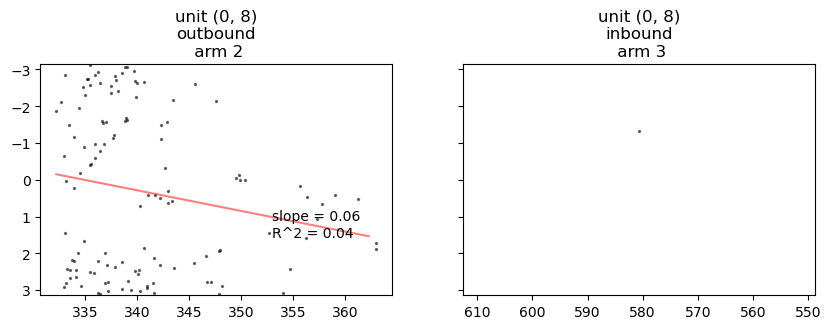

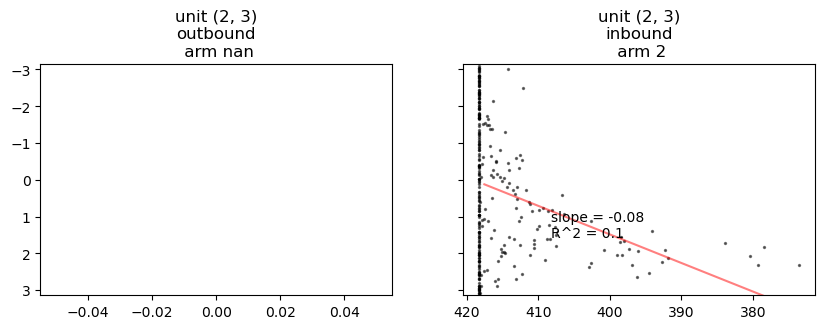

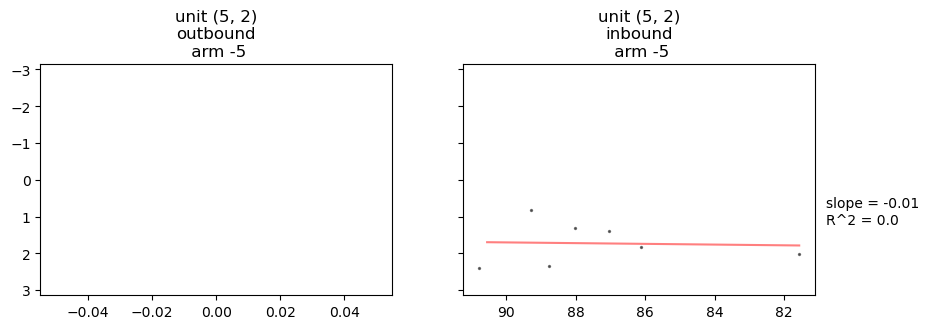

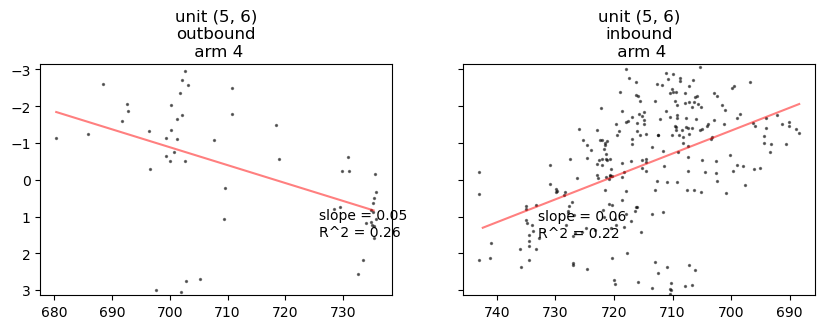

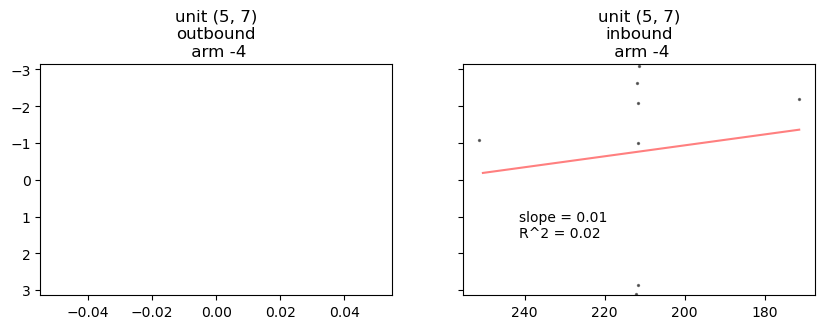

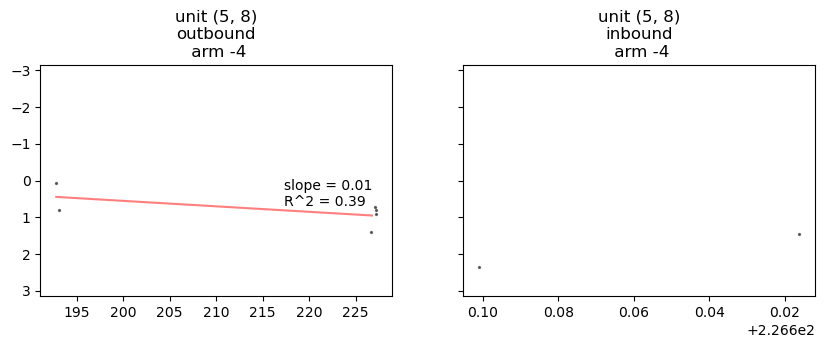

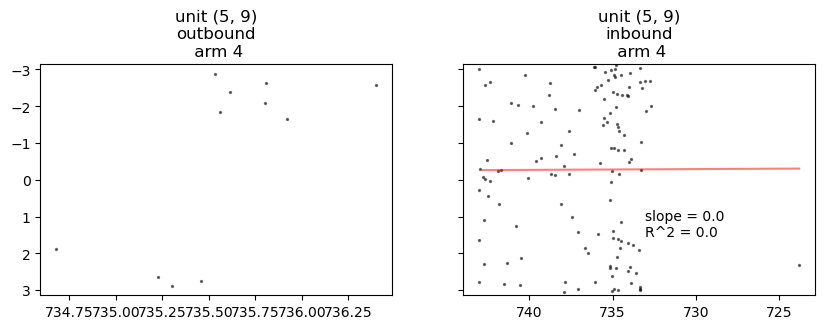

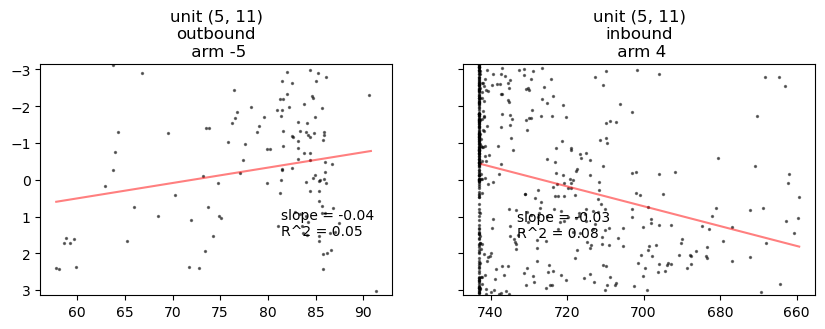

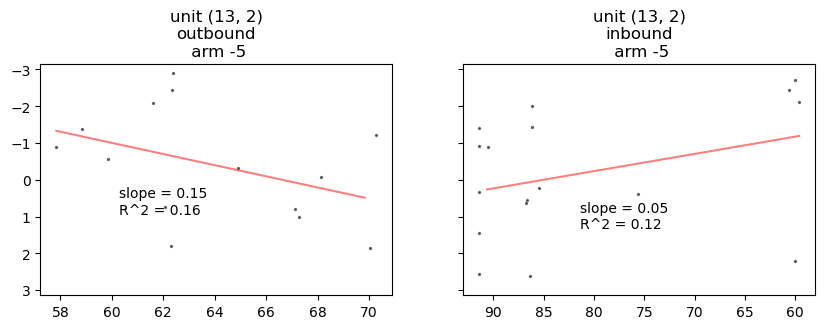

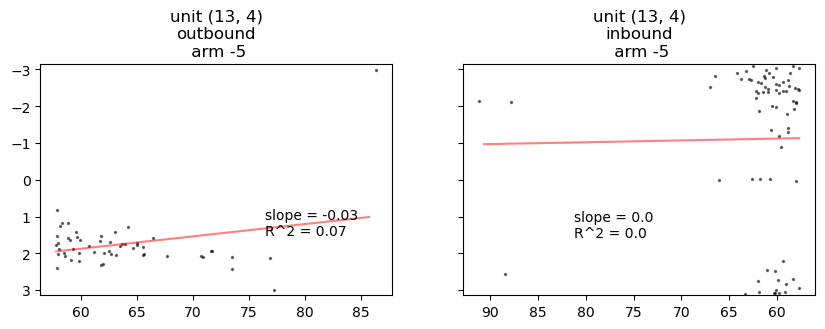

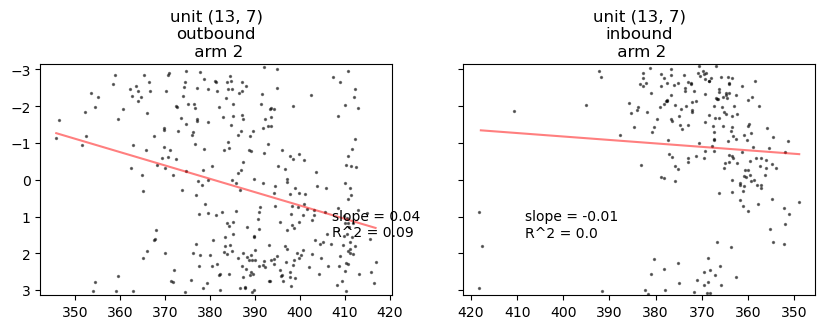

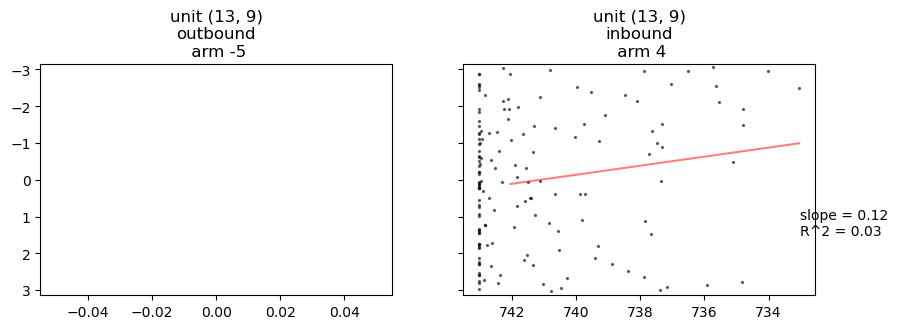

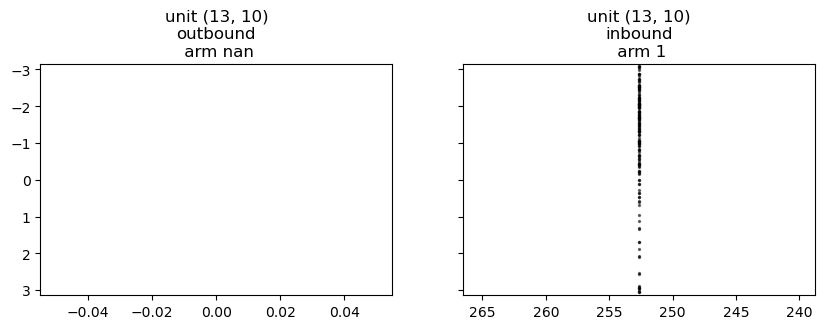

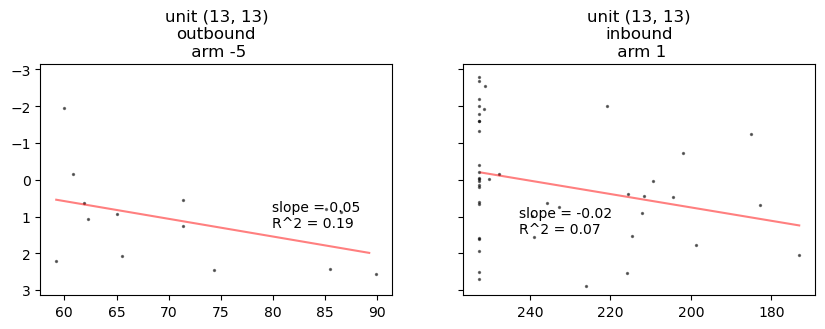

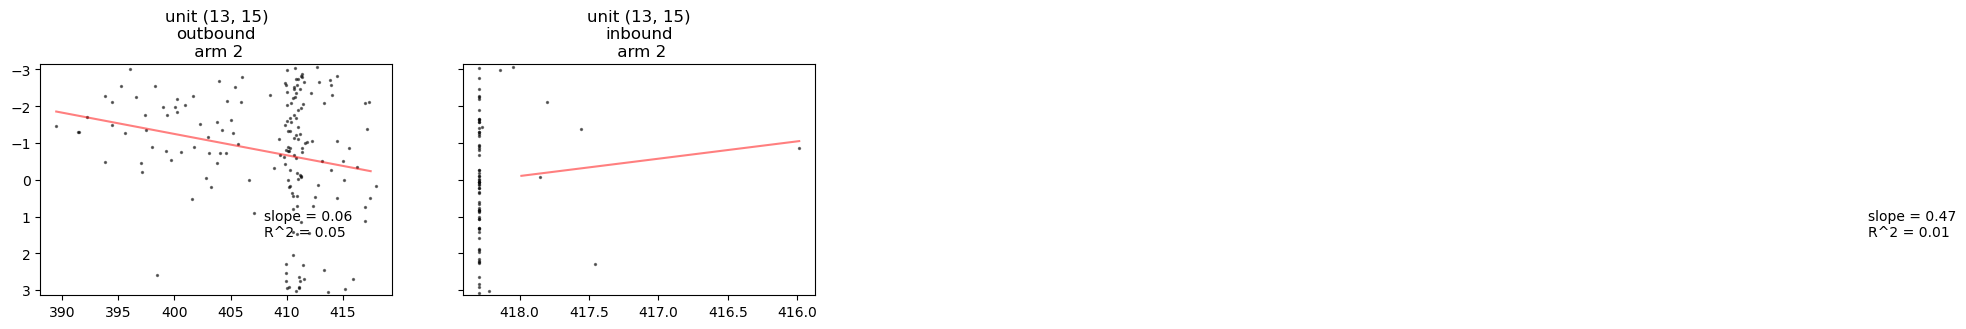

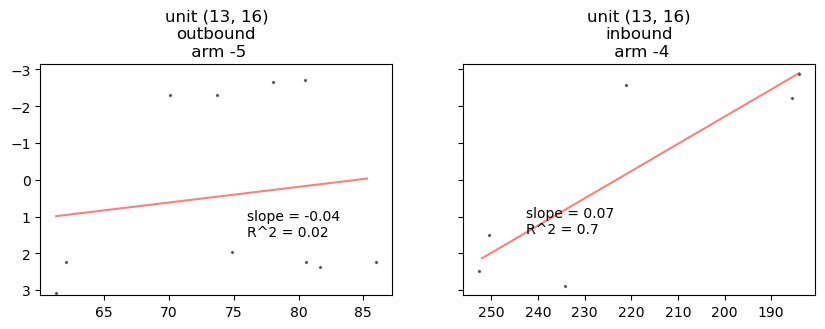

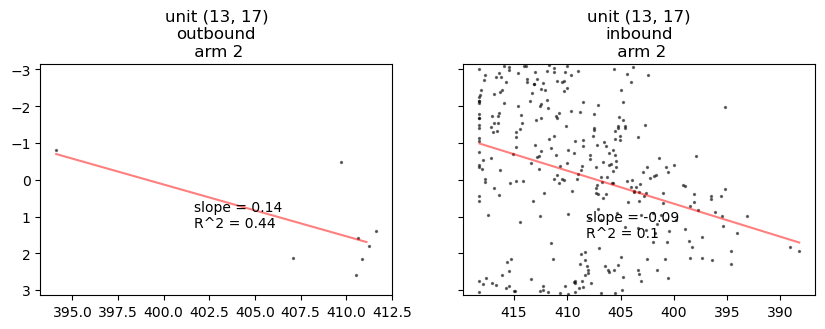

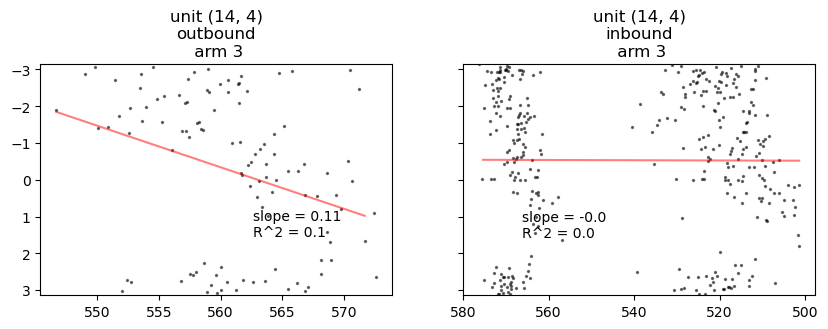

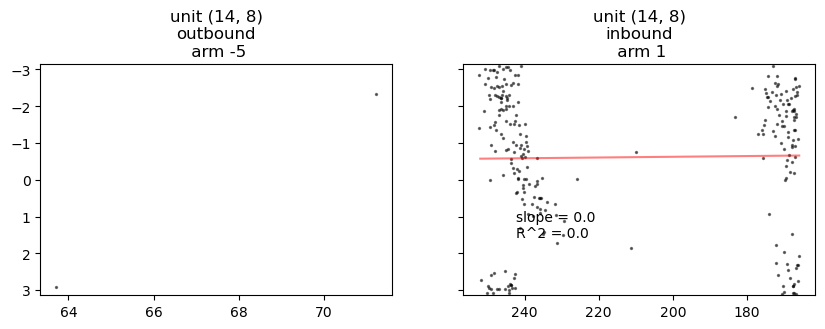

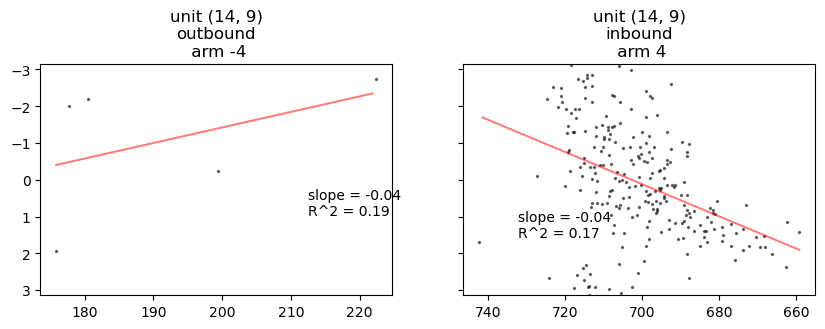

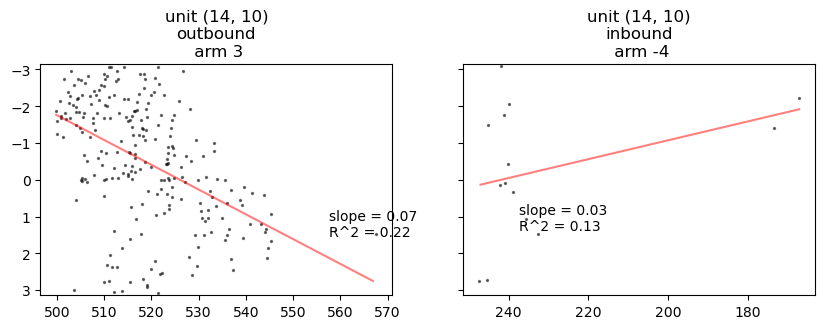

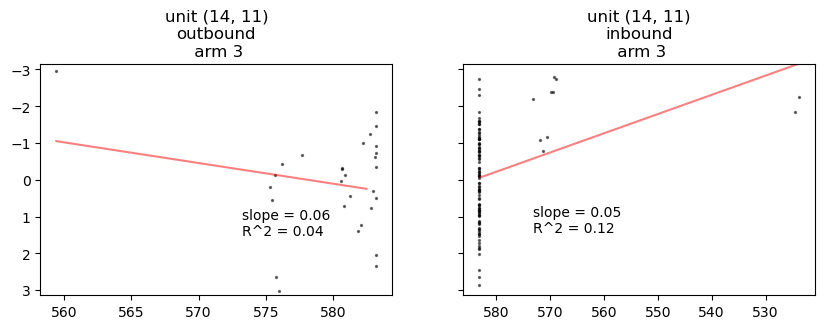

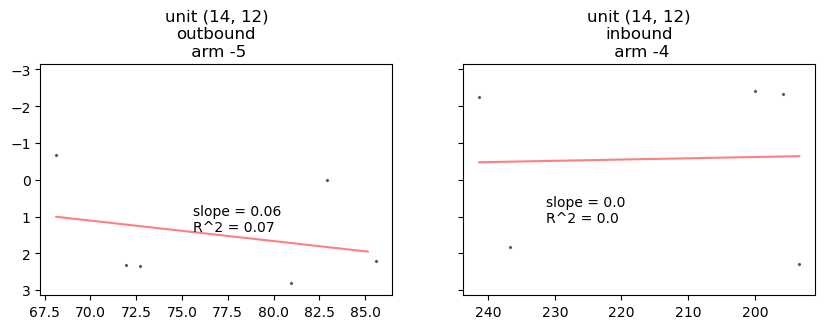

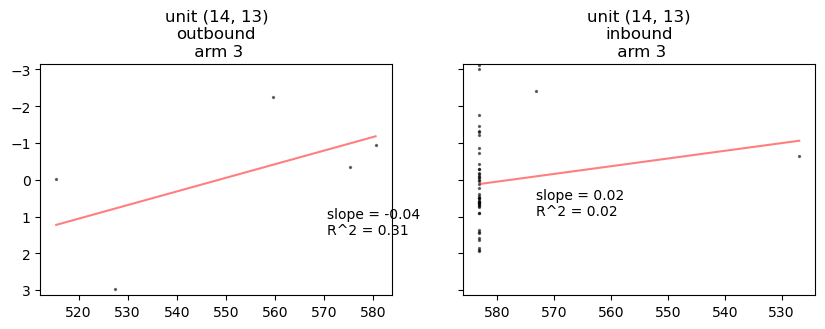

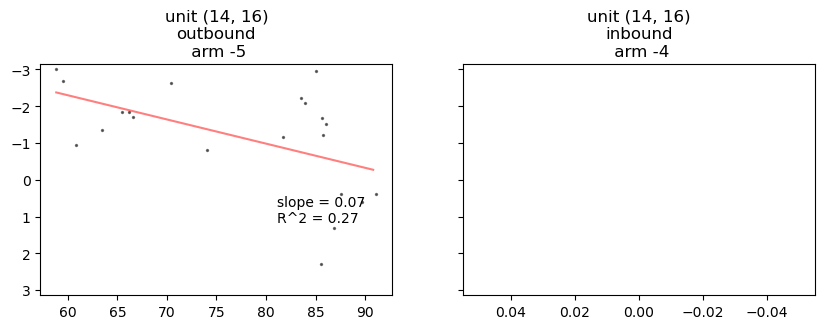

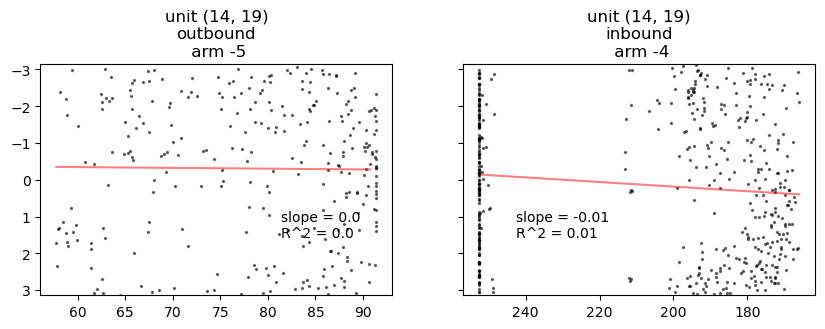

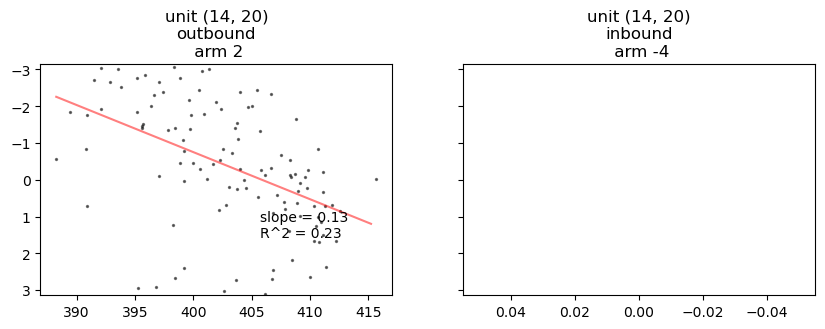

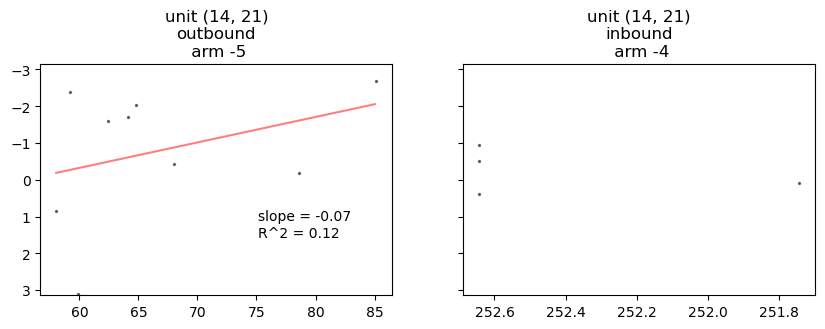

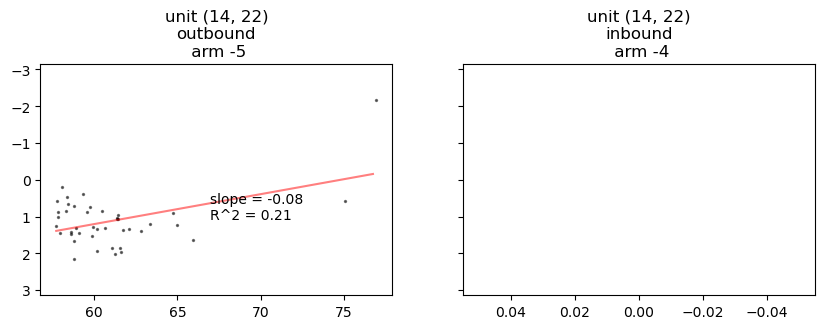

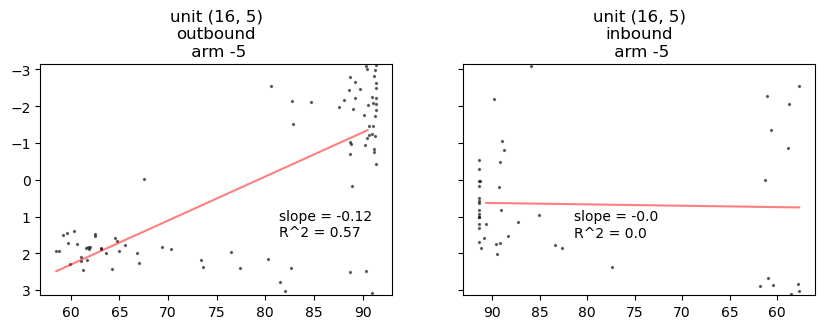

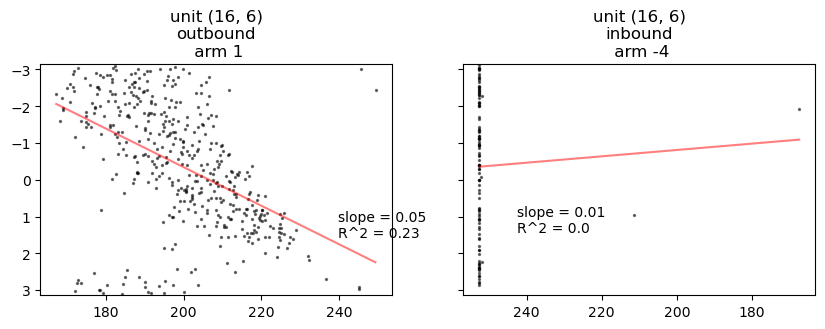

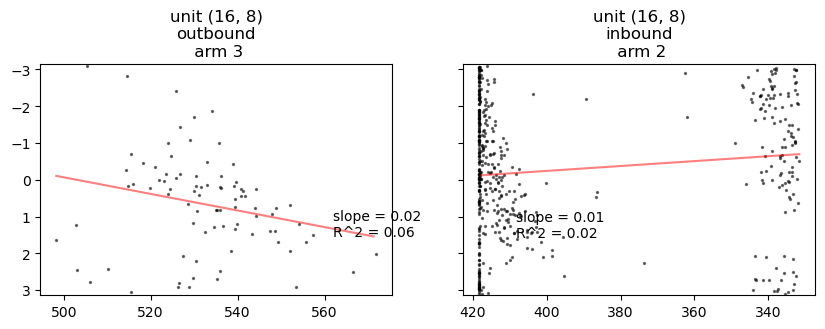

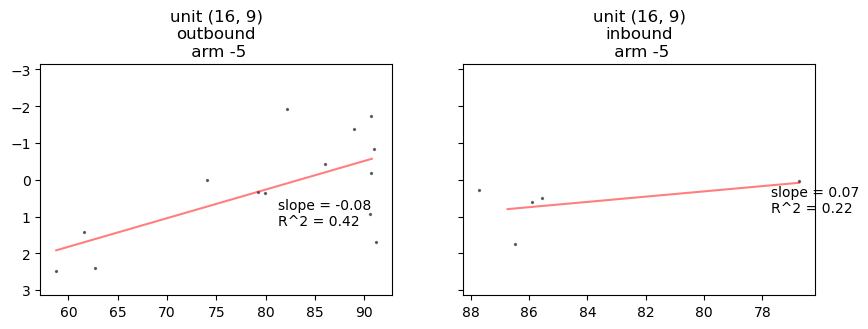

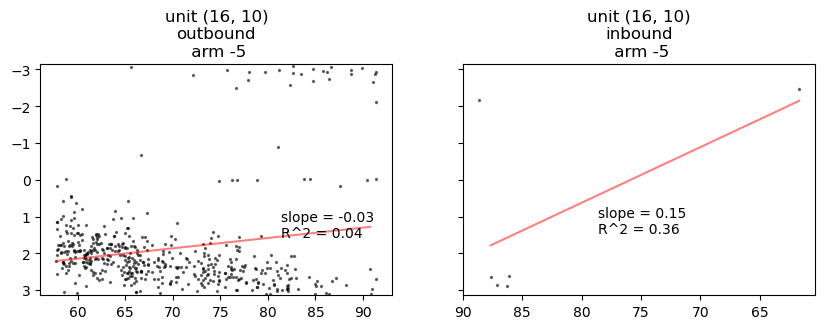

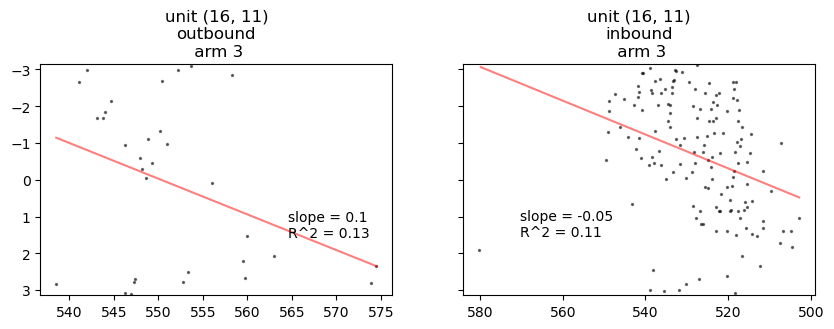

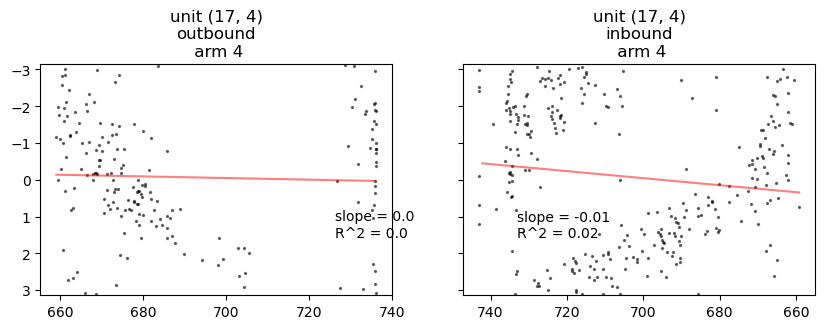

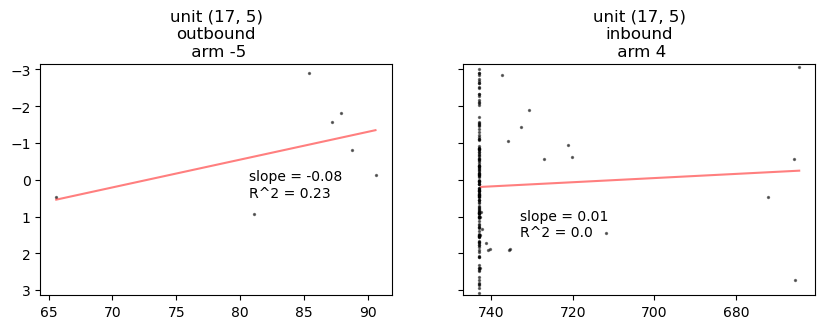

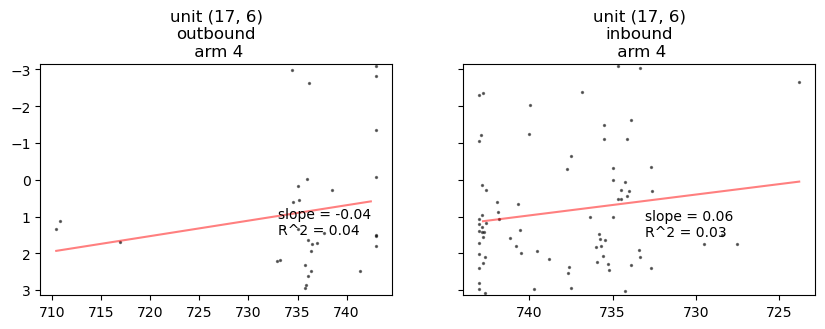

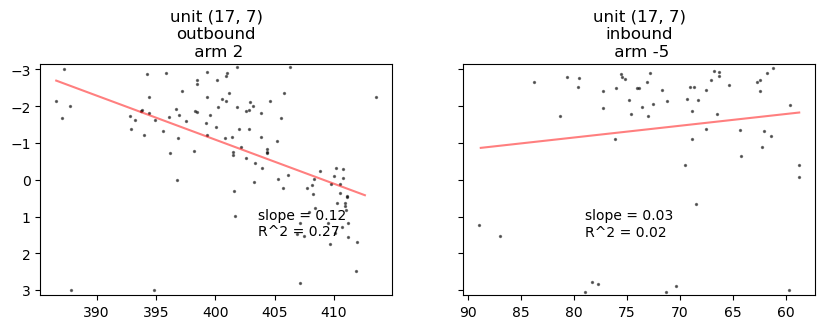

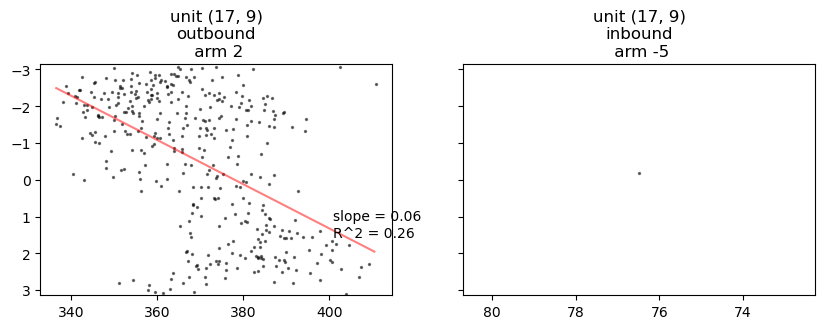

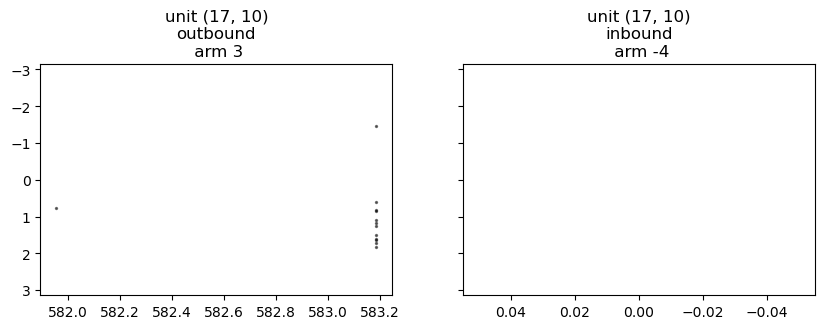

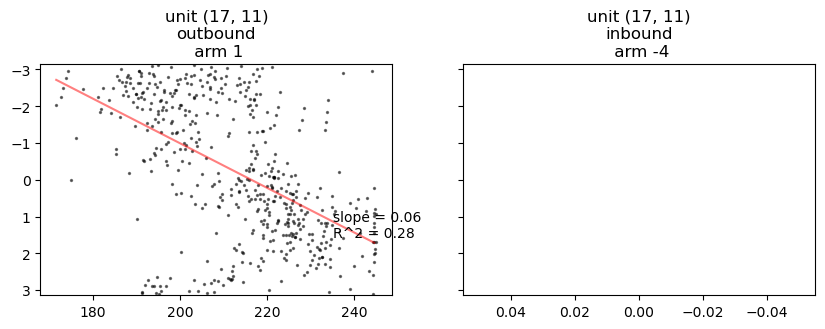

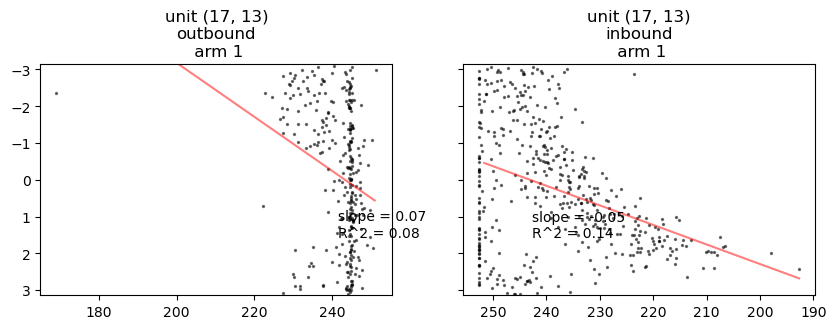

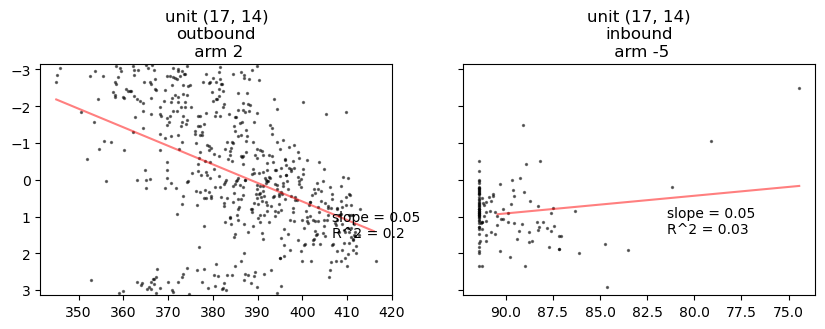

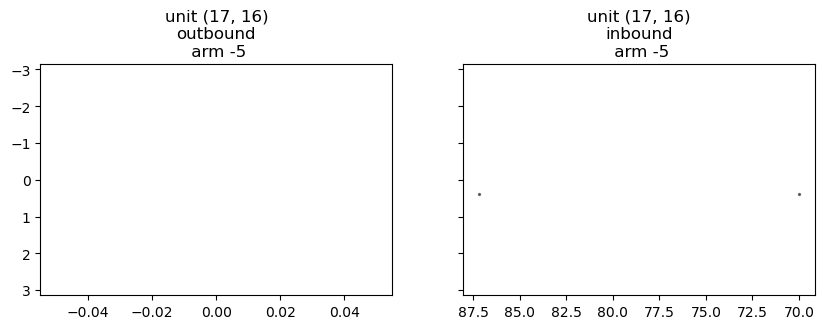

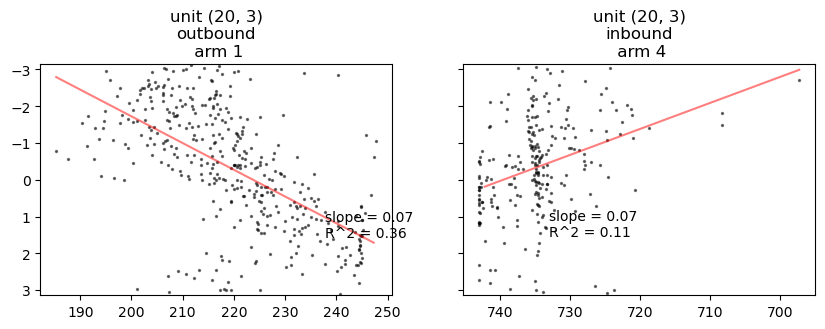

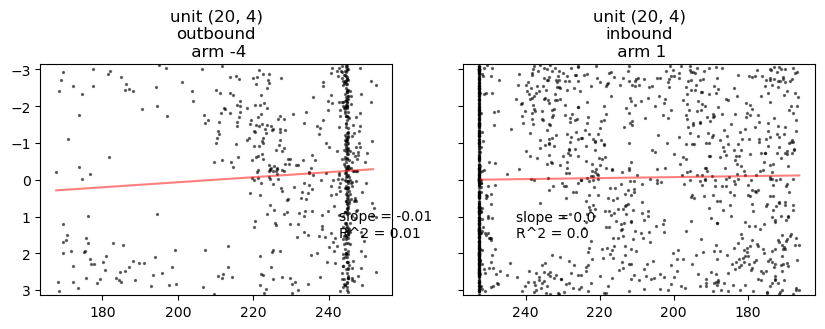

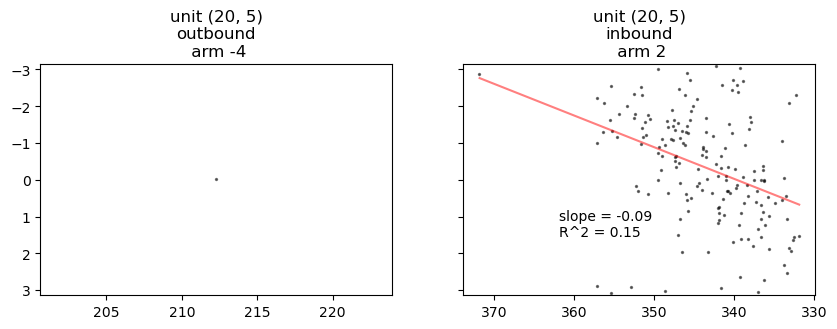

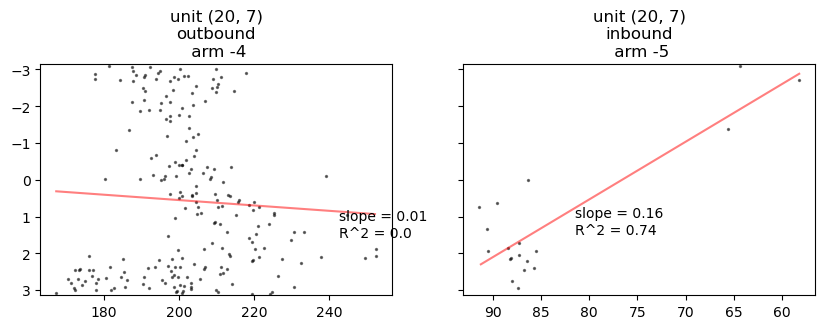

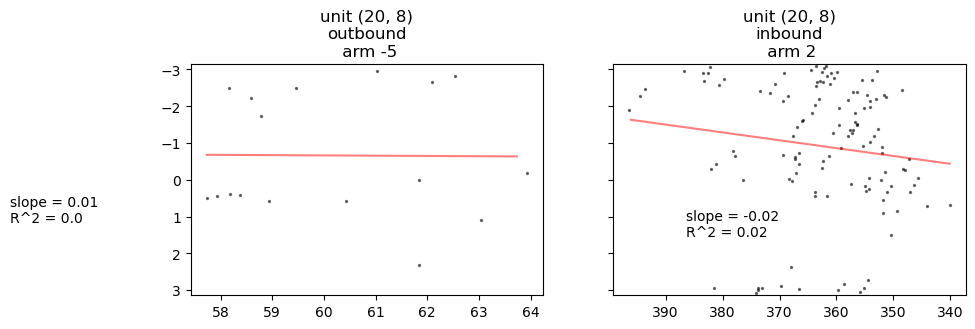

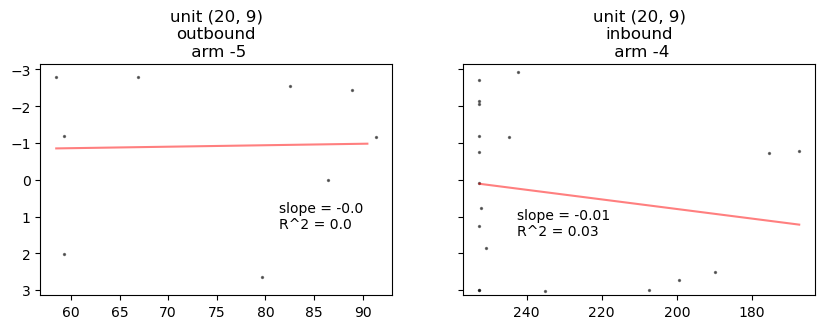

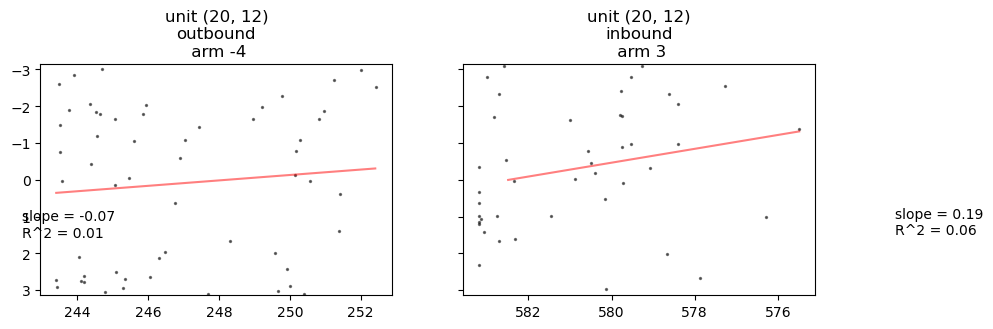

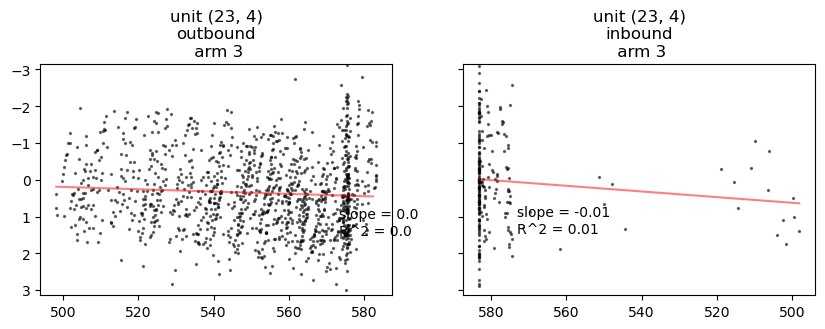

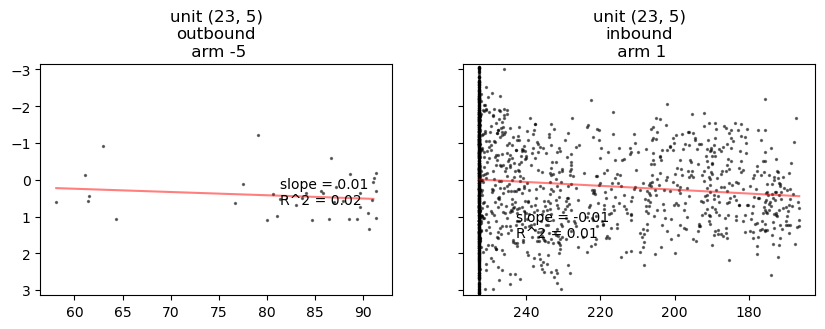

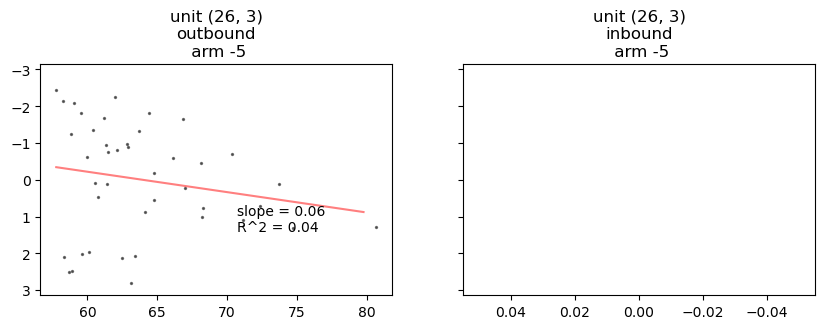

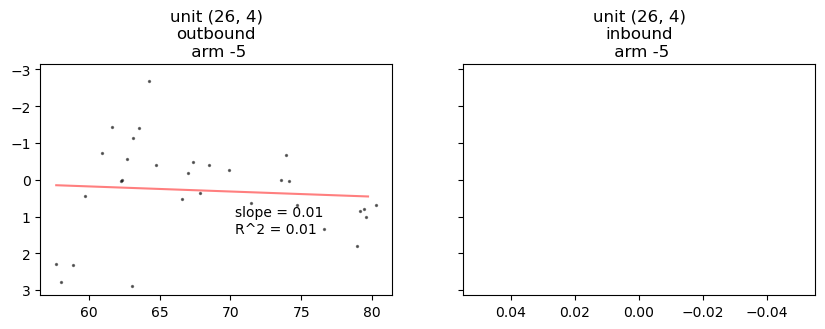

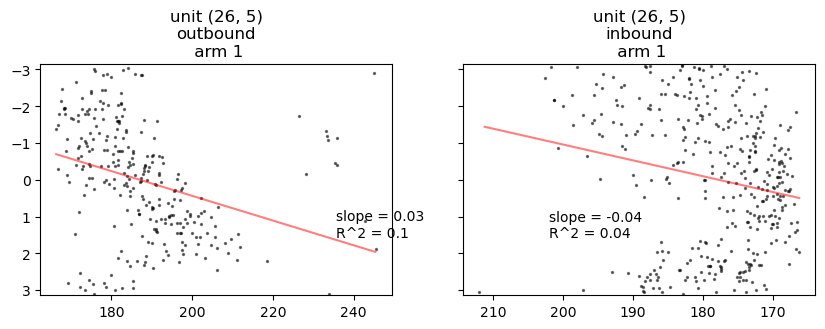

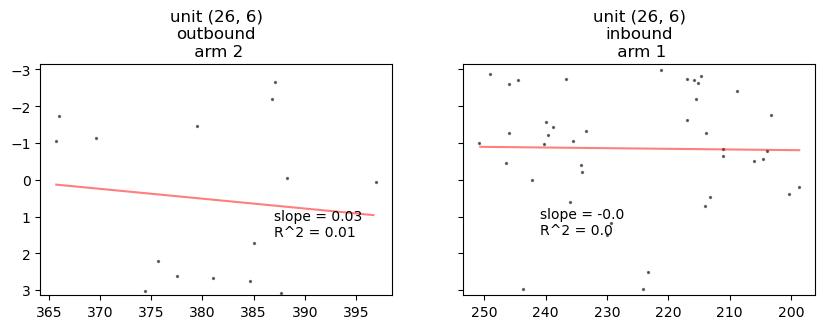

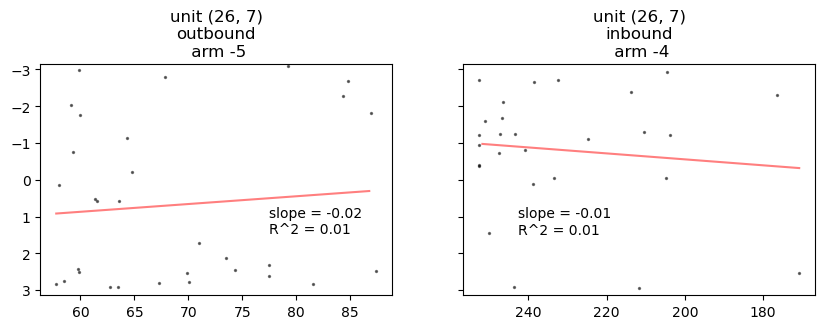

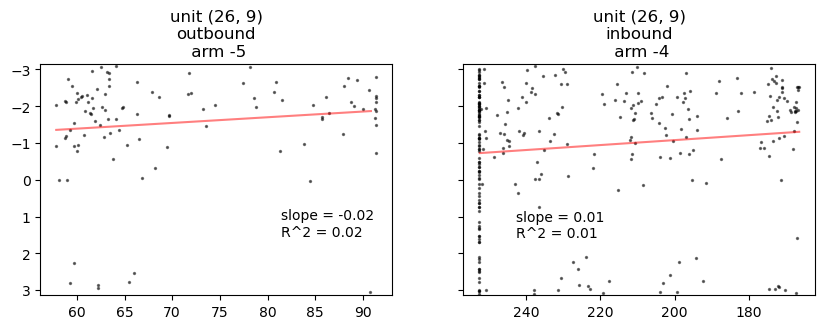

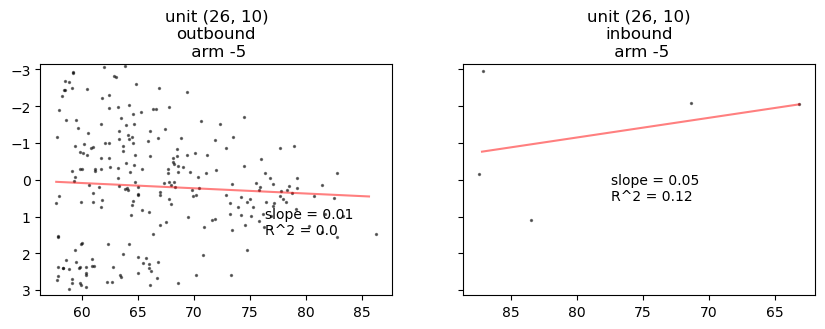

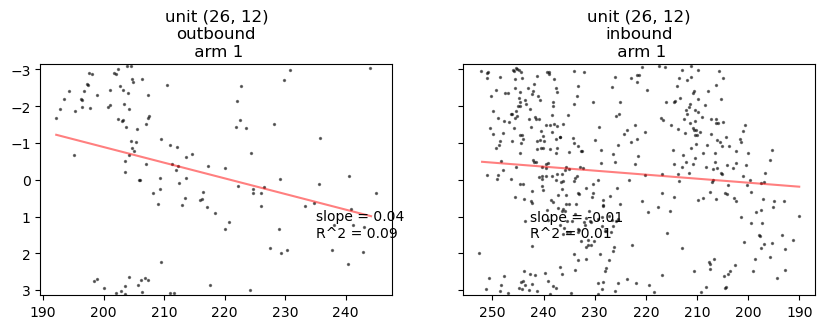

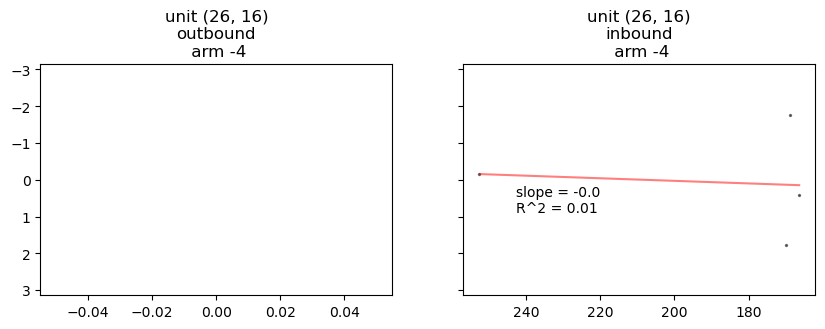

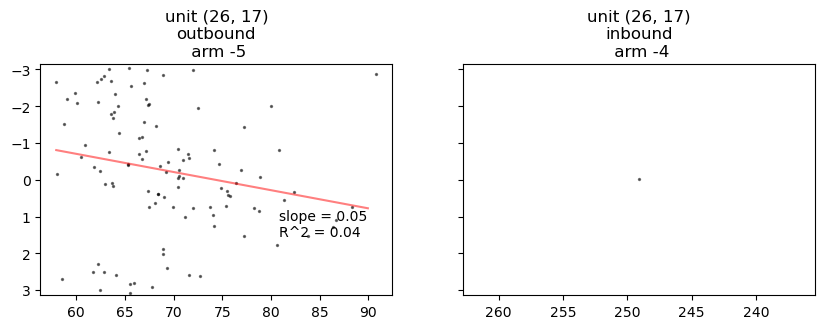

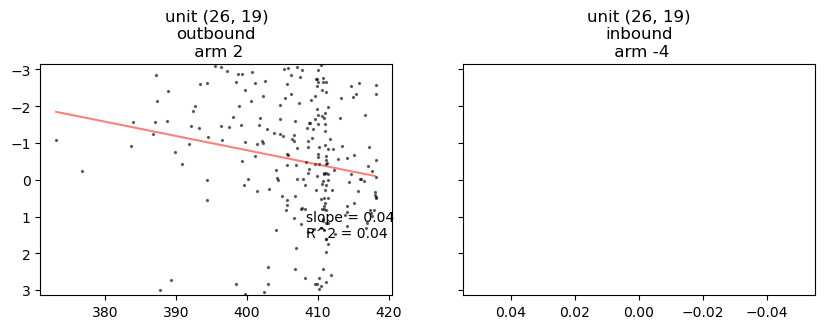

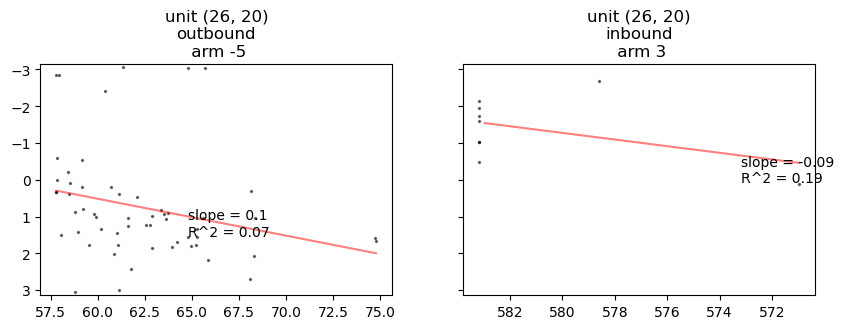

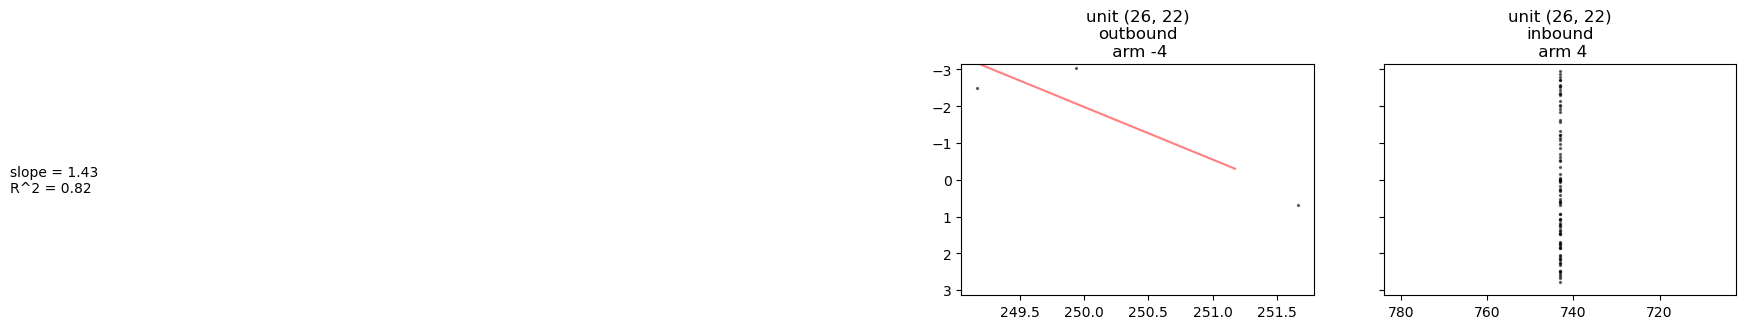

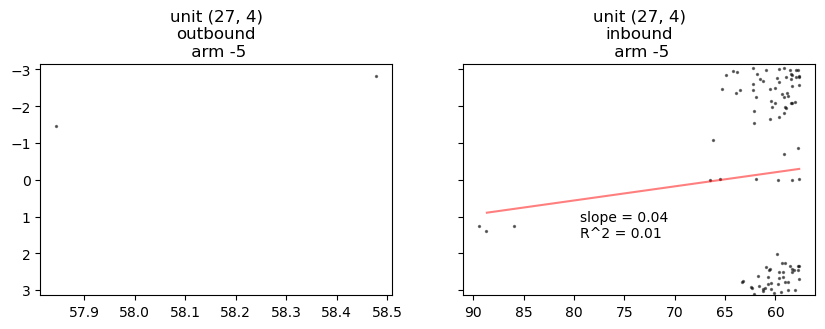

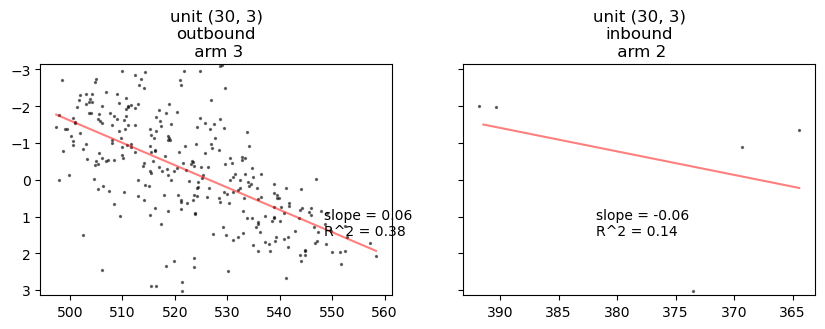

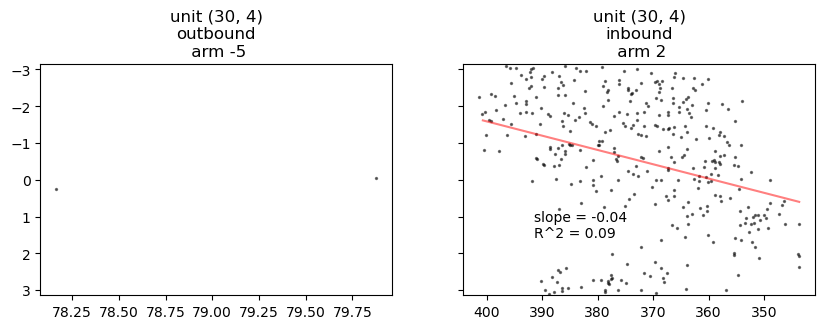

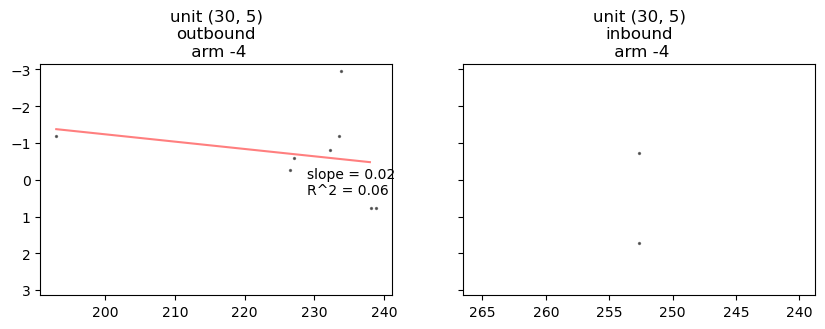

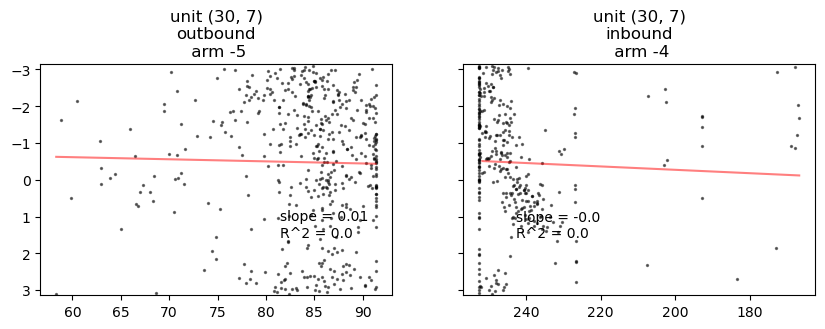

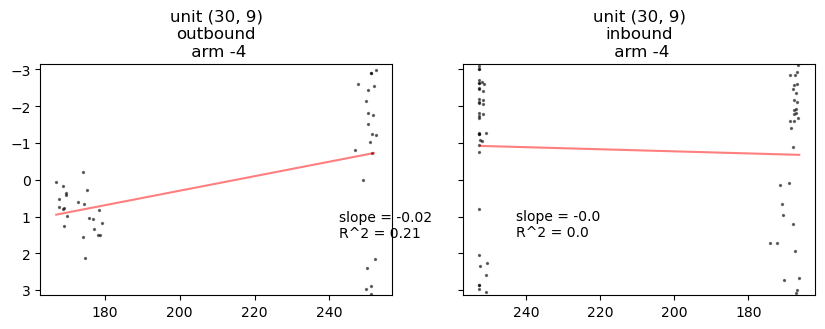

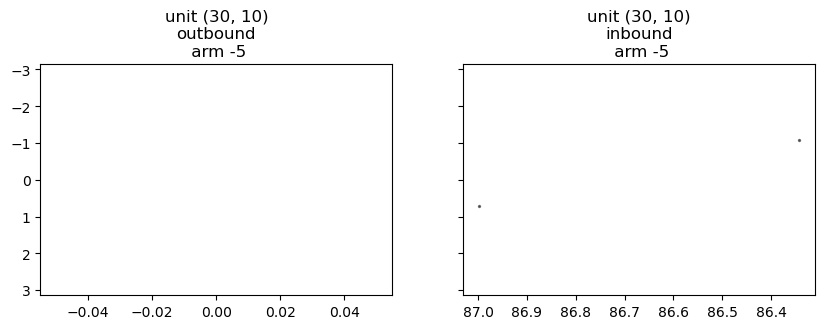

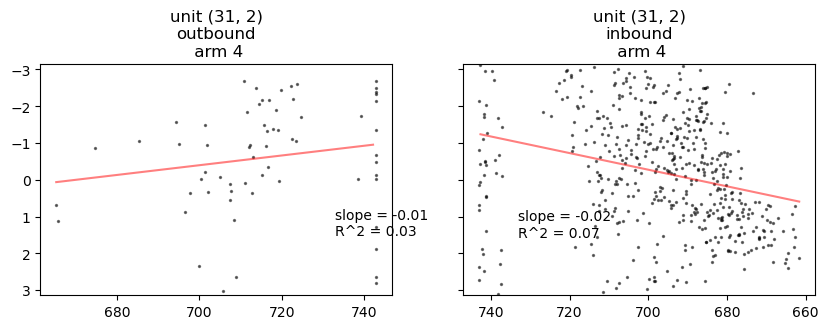

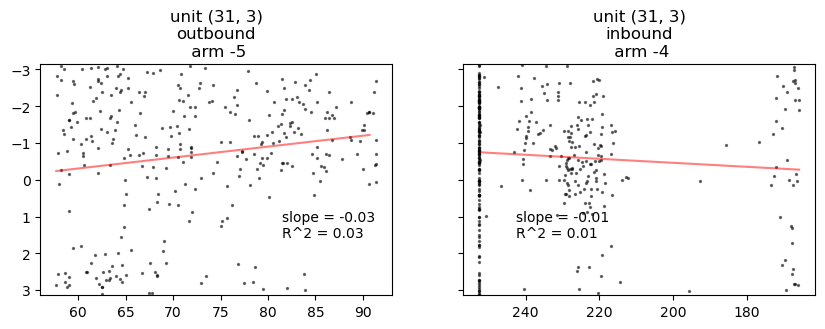

In [114]:
coef_all_cont = []
score_all_cont = []

for unitID in cell_list:
    pos_phase,arms = return_theta_phase_location(pos1d,pos2d,theta_df,nwb_units_all,unitID)
    model,score = fit_theta_phase_location(pos_phase,arms)

    # find direction
    scores = np.array([score['outbound'],score['inbound']])
    if np.sum(np.isnan(scores)) == 2:
        continue
    direction = np.nanargmax(scores)
    if direction == 0:
        coef = model['outbound'].coef_[0][0]
    else:
        coef = -model['inbound'].coef_[0][0]
    
    score_all_cont.append(scores[direction])
    coef_all_cont.append(coef)

    # plot
    plot_theta_phase_precession(pos_phase,arms,model,score,unitID)

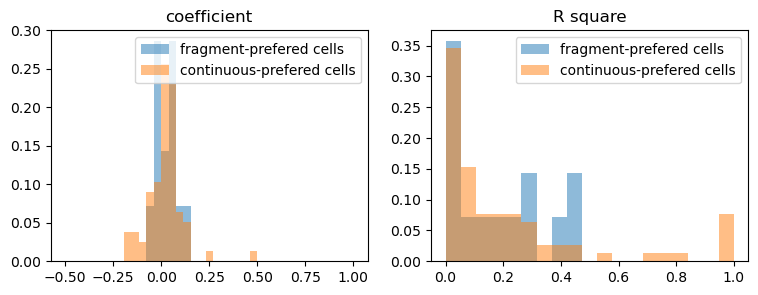

In [115]:
fig, axes = plt.subplots(1,2,figsize = (9,3))

for i in range(2):
    if i == 0:
        data1 = coef_all_frag
        data2 = coef_all_cont
        title = 'coefficient'
        bins_ = np.linspace(-0.5,1,40)
    elif i == 1:
        data1 = score_all_frag
        data2 = score_all_cont
        title = 'R square'
        bins_ = np.linspace(0,1,20)
 
    axes[i].hist(data1,bins = bins_,alpha = 0.5,
             weights = np.ones(len(data1))/len(data1), label = 'fragment-prefered cells')
    axes[i].hist(data2,bins = bins_,alpha = 0.5,
             weights = np.ones(len(data2))/len(data2), label = 'continuous-prefered cells')
    axes[i].set_title(title);
    
    #axes[i].set_xticks(np.arange(0,80,10)+0.5);
    #axes[i].set_xticklabels(np.arange(0,80,10));
    axes[i].legend()